### Set parameters and names

In [43]:
from CustomObjects import *

In [44]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        K = keras.backend
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [45]:
np.random.seed(42)
tf.random.set_seed(42)
%matplotlib inline

In [46]:
INPUT_GENES    = 'ALL'
INPUT_FEATURES = 'X_FC'
INPUT_NORM     = '_z'
INPUT_NAME     = f'{INPUT_GENES}_{INPUT_FEATURES}{INPUT_NORM}'
INPUT_TRAIN   =f'../data/training/{INPUT_NAME}_training.csv'
INPUT_VAL   = f'../data/validation/{INPUT_NAME}_validation.csv'
INPUT_TEST    =f'../data/test/{INPUT_NAME}_test.csv'
#
CODINGS_SIZE = 6
#
#MODEL_ID=f'VAE1_{CODINGS_SIZE}D_{CHIP_NORM}_{INPUT_NAME}'
MODEL_ID=f'AE_{CODINGS_SIZE}D_{INPUT_NAME}'

DIR_FIG=f'../figures/{MODEL_ID}/'
DIR_DATA=f'../data/{MODEL_ID}/'
! mkdir -p {DIR_FIG}
! mkdir -p {DIR_DATA}
# set colors
CENTER=None

### Import ChIP and RNA data

In [47]:
# Import input data 
X_train = pd.read_csv( INPUT_TRAIN ).set_index('GENE')
X_val = pd.read_csv( INPUT_VAL ).set_index('GENE')
X_test = pd.read_csv( INPUT_TEST ).set_index('GENE')

#
X = pd.concat((X_test,X_val,X_train)).sort_index()
#
assert X.isna().any().sum() == 0
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(10796, 38)
(2700, 38)
(1500, 38)


In [ ]:
violins(X_train,COL_DICT=CT_COL_DICT, SAVEFIG=f'{DIR_FIG}/training_violins.png',X_LAB='Z-score',TITLE='Training set',SAT=0.7)
violins(X_val,COL_DICT=CT_COL_DICT, SAVEFIG=f'{DIR_FIG}/validation_violins.png',X_LAB='Z-score',TITLE='Validation set',SAT=0.7)
violins(X_test,COL_DICT=CT_COL_DICT, SAVEFIG=f'{DIR_FIG}/test_violins.png',     X_LAB='Z-score',TITLE='Test set',SAT=0.7)

### Plot training history

In [49]:

def plot_training_history(history, color_dict, save_path=None):
    N = np.arange(1, len(history.history['loss']) + 1)

    fig, axs = plt.subplots(4, 1, figsize=(6, 10), sharex=True)

    # Plot cosine similarity
    axs[0].plot(N, history.history['cosine_similarity'], linestyle='solid', color=color_dict['training'], label="Sc_train")
    if 'val_cosine_similarity' in history.history:
        axs[0].plot(N, history.history['val_cosine_similarity'], linestyle='solid', color=color_dict['validation'], label="Sc_val")
        axs[0].legend(loc='best')
    axs[0].set_ylabel("Cosine Similarity")
    axs[0].set_ylim(-1, 1)
    axs[0].grid(True)
    sns.despine(left=True, bottom=True, right=True, ax=axs[0])

    # Plot RMSE
    axs[1].plot(N, history.history['root_mean_squared_error'], linestyle='solid', color=color_dict['training'], label="RMSE_train")
    if 'val_root_mean_squared_error' in history.history:
        axs[1].plot(N, history.history['val_root_mean_squared_error'], linestyle='solid', color=color_dict['validation'], label="RMSE_val")
    axs[1].set_ylabel("Root Mean Squared Error")
    axs[1].grid(True)
    sns.despine(left=True, bottom=True, right=True, ax=axs[1])

    # Plot loss
    axs[2].plot(N, history.history['loss'], linestyle='solid', color=color_dict['training'], label="Loss_train")
    if 'val_loss' in history.history:
        axs[2].plot(N, history.history['val_loss'], linestyle='solid', color=color_dict['validation'], label="Loss_val")
    axs[2].set_ylabel("Loss")
    axs[2].grid(True)
    sns.despine(left=True, bottom=True, right=True, ax=axs[2])

    # Plot learning rate
    axs[3].plot(N, history.history['lr'], linestyle='dotted', color='black', label="lr")
    lr = "{:.2e}".format(history.history['lr'][-1])
    axs[3].set_xlabel("Epoch #")
    axs[3].set_ylabel("Learning Rate")
    axs[3].set_yscale('log')
    axs[3].set_ylim(1e-9, max(history.history['lr']) * 10)
    axs[3].legend(loc='best')
    axs[3].grid(True)
    sns.despine(left=True, bottom=True, right=True, ax=axs[3])

    # Show the plots
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)


### Custom loss: MSE - CosineSimilarity

In [50]:
def custom_loss(y_true, y_pred):
    # Cosine Similarity Loss
    cosine_loss = tf.keras.losses.CosineSimilarity(axis=1)(y_true, y_pred)
    
    # Mean Squared Error (MSE) Loss
    mse_loss = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
    
    # Sum of Cosine Similarity and MSE
    combined_loss = cosine_loss + mse_loss
    
    return combined_loss

### Encoder and Decoder subclasses

In [51]:
from tensorflow.keras import layers, Model

# Hyperparameters
N_FEATURES = X_train.shape[1]
START_LR = 0.05
ACT_FUN = 'prelu'
if ACT_FUN == 'prelu':
    ACT_FUN = None
CODE_ACT_FUN = 'relu'
NUM_HLAYERS = 1
NUM_NEURONS_SCALE = 1
BATCH_NORM = True
BATCH_SIZE = 64
metrics = [tf.keras.metrics.CosineSimilarity(), tf.keras.metrics.RootMeanSquaredError()]

# Calculate the number of neurons for each layer
num_neurons_list = [N_FEATURES]
num_neurons = N_FEATURES
for i in range(NUM_HLAYERS):
    num_neurons = int(max(CODINGS_SIZE * 2, num_neurons // NUM_NEURONS_SCALE))
    num_neurons_list.append(num_neurons)

class Encoder(Model):
    def __init__(self, num_neurons_list, ACT_FUN, BATCH_NORM):
        super(Encoder, self).__init__()
        self.layers_list = []

        for i, num_neurons in enumerate(num_neurons_list):
            layer_name = f'Dense_{i}_E'
            self.layers_list.append(layers.Dense(num_neurons, activation=ACT_FUN, name=layer_name))
            if ACT_FUN is None:
                self.layers_list.append(layers.PReLU(name=f'PReLU_{i}_E'))
            if BATCH_NORM and i != len(num_neurons_list) - 1:
                self.layers_list.append(layers.BatchNormalization(name=f'BN_{i}_E'))

        self.layers_list.append(layers.Dense(CODINGS_SIZE, activation=CODE_ACT_FUN, name=f'Code'))

    def call(self, inputs):
        x = inputs
        for layer in self.layers_list:
            x = layer(x)
        return x

    def summary(self, input_shape):
        x = tf.keras.Input(shape=input_shape,name='Input')
        model = tf.keras.Model(inputs=[x], outputs=self.call(x))
        return model.summary()

class Decoder(Model):
    def __init__(self, num_neurons_list, ACT_FUN, BATCH_NORM):
        super(Decoder, self).__init__()
        self.layers_list = []

        for i, num_neurons in enumerate(reversed(num_neurons_list)):
            layer_name = f'Dense_{i}_D'
            self.layers_list.append(layers.Dense(num_neurons, activation=ACT_FUN, name=layer_name))
            if ACT_FUN is None:
                self.layers_list.append(layers.PReLU(name=f'PReLU_{i}_D'))
            if BATCH_NORM and i < len(num_neurons_list)-1:
                self.layers_list.append(layers.BatchNormalization(name=f'BN_{i}_D'))

        # Add the final layer with appropriate activation and name
        #self.layers_list.append(layers.Dense(N_FEATURES, activation=ACT_FUN if ACT_FUN is not None else 'linear', name='Output_D'))

    def call(self, inputs):
        x = inputs
        for layer in self.layers_list:
            x = layer(x)
        return x

    def summary(self, input_shape):
        x = tf.keras.Input(shape=input_shape,name='Input')
        model = tf.keras.Model(inputs=[x], outputs=self.call(x))
        return model.summary()


# Build Encoder
encoder = Encoder(num_neurons_list, ACT_FUN, BATCH_NORM)
encoder.build(input_shape=(None, N_FEATURES))
encoder.summary(input_shape=(N_FEATURES,))


Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 38)]              0         
                                                                 
 Dense_0_E (Dense)           (None, 38)                1482      
                                                                 
 PReLU_0_E (PReLU)           (None, 38)                38        
                                                                 
 BN_0_E (BatchNormalization)  (None, 38)               152       
                                                                 
 Dense_1_E (Dense)           (None, 38)                1482      
                                                                 
 PReLU_1_E (PReLU)           (None, 38)                38        
                                                                 
 Code (Dense)                (None, 6)                 234

In [52]:

# Build Decoder
decoder = Decoder(num_neurons_list, ACT_FUN, BATCH_NORM)
decoder.build(input_shape=(None, CODINGS_SIZE))
decoder.summary(input_shape=(CODINGS_SIZE,))


Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 6)]               0         
                                                                 
 Dense_0_D (Dense)           (None, 38)                266       
                                                                 
 PReLU_0_D (PReLU)           (None, 38)                38        
                                                                 
 BN_0_D (BatchNormalization)  (None, 38)               152       
                                                                 
 Dense_1_D (Dense)           (None, 38)                1482      
                                                                 
 PReLU_1_D (PReLU)           (None, 38)                38        
                                                                 
Total params: 1,976
Trainable params: 1,900
Non-trainable 

Epoch 1/300


2024-07-04 12:08:20.081867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


164/169 [============================>.] - ETA: 0s - loss: -0.5187 - cosine_similarity: 0.8122 - root_mean_squared_error: 0.5418

2024-07-04 12:08:21.875981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


169/169 [==============================] - 2s 11ms/step - loss: -0.5220 - cosine_similarity: 0.8133 - root_mean_squared_error: 0.5397 - val_loss: 0.1430 - val_cosine_similarity: 0.7720 - val_root_mean_squared_error: 0.9566 - lr: 0.0500
Epoch 2/300
169/169 [==============================] - 2s 10ms/step - loss: -0.6967 - cosine_similarity: 0.8827 - root_mean_squared_error: 0.4313 - val_loss: -0.0131 - val_cosine_similarity: 0.7745 - val_root_mean_squared_error: 0.8726 - lr: 0.0500
Epoch 3/300
169/169 [==============================] - 2s 10ms/step - loss: -0.7391 - cosine_similarity: 0.8991 - root_mean_squared_error: 0.4000 - val_loss: -0.4594 - val_cosine_similarity: 0.8147 - val_root_mean_squared_error: 0.5961 - lr: 0.0500
Epoch 4/300
169/169 [==============================] - 2s 10ms/step - loss: -0.7474 - cosine_similarity: 0.9019 - root_mean_squared_error: 0.3931 - val_loss: -0.5163 - val_cosine_similarity: 0.8429 - val_root_mean_squared_error: 0.5715 - lr: 0.0500
Epoch 5/300
169/1

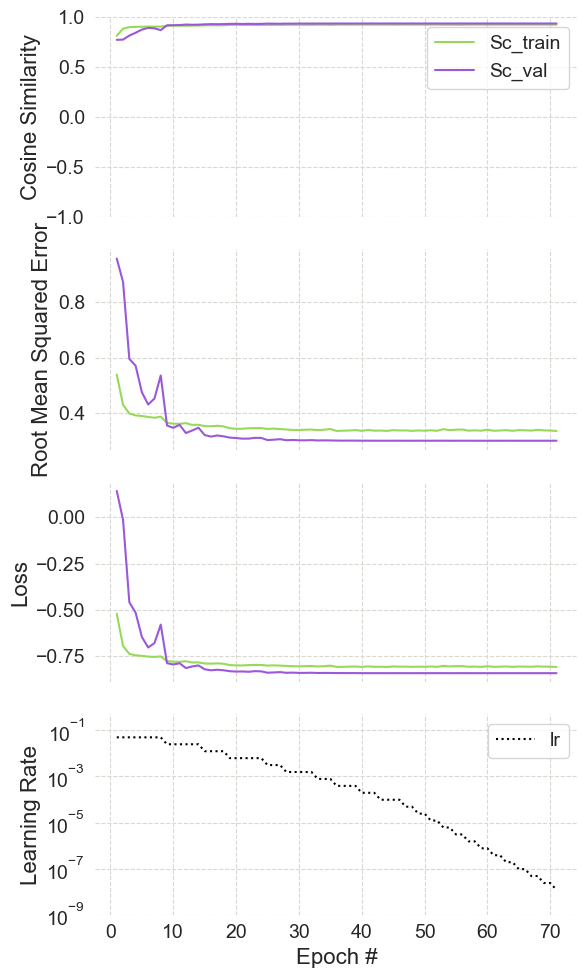

In [53]:
tf.random.set_seed(42)
np.random.seed(42)

# Build Autoencoder
inputs = layers.Input(shape=(N_FEATURES,))
codings = encoder(inputs)
reconstructions = decoder(codings)
AE = Model(inputs, reconstructions, name='autoencoder')
# Compile Autoencoder
AE.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=START_LR), loss=custom_loss, metrics=metrics)


# Callbacks
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, verbose=1, min_delta=0, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=2, verbose=1, factor=0.5, min_lr=1e-9)
my_callbacks = [early_stop, reduce_lr]

# Training
with tf.device('/cpu:0'):
    AE.fit(X_train, X_train, 
                            epochs=300, 
                            batch_size=BATCH_SIZE, 
                            validation_data=(X_val, X_val),
                            callbacks=my_callbacks)
plot_training_history(AE.history, SET_COL_DICT, save_path=f'{DIR_FIG}training_plot.pdf')

In [72]:
def AE_transform(X, autoencoder, encoder, set_label, BATCH_SIZE):
    # Reconstruct X -> R
    R = autoencoder.predict(X, batch_size=BATCH_SIZE)
    
    # Get errors
    Sc = -np.array(tf.keras.losses.CosineSimilarity(reduction='none', axis=1)(np.array(X, dtype='float32'), R))
    Sc_mean = np.round(float(Sc.mean()), 2)
    Sc_perc = np.round(np.percentile(Sc, [5, 95]), 2)
    #print(f"Sc (mean, [5th-95th]) {set_label}: {Sc_mean} [{Sc_perc[0]}-{Sc_perc[1]}]")
    
    RMSE = np.sqrt(np.array(tf.keras.losses.MSE(X, R)))
    RMSE_mean = np.round(float(RMSE.mean()), 2)
    RMSE_perc = np.round(np.percentile(RMSE, [5, 95]), 2)
    #print(f"MSE (mean, [5th-95th]) {set_label}: {MSE_mean} [{MSE_perc[0]}-{MSE_perc[1]}]")

    Err = pd.DataFrame({'RMSE': RMSE, 'Sc': Sc})

    # Get latent code 
    C = encoder(np.array(X))
    C = pd.DataFrame(C, columns=[f'AE{x}' for x in range(1, C.shape[1] + 1)])

    # Re-annotate Rec. with feature names and index
    FEATURE_NAMES = X.columns.to_list()
    R = pd.DataFrame(R, columns=FEATURE_NAMES)
    R = pd.concat((R, C, Err), axis=1)
    R = R.set_index(X.index)
    R['SET'] = set_label

    # Return results as a list
    results = {
        'Set': set_label,
        'Sc':       f'{Sc_mean} [{Sc_perc[0]}-{Sc_perc[1]}]',
        'RMSE': f'{RMSE_mean} [{RMSE_perc[0]}-{RMSE_perc[1]}]',
    }
    
    return R, results

# Use the function for both train and test data
R_train, metrics_train = AE_transform(X_train, AE, encoder, 'training', BATCH_SIZE=BATCH_SIZE)
R_val, metrics_val = AE_transform(X_val, AE, encoder, 'validation', BATCH_SIZE=BATCH_SIZE)
R_test, metrics_test = AE_transform(X_test, AE, encoder, 'test', BATCH_SIZE=BATCH_SIZE)

# Combine dataframes
R_X = pd.concat((R_train, R_val, R_test)).sort_index()
# Combine metrics
metrics_df = pd.DataFrame([metrics_train, metrics_val, metrics_test])
# Display metrics
metrics_df.to_csv(f'{DIR_DATA}metrics.csv', index=False)
metrics_df


21/43 [=============>................] - ETA: 0s

2024-07-04 13:44:04.265586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/24 [================>.............] - ETA: 0s

2024-07-04 13:44:04.808284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 0s 15ms/step


2024-07-04 13:44:05.339142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


,Set,Sc,RMSE
0,training,0.93 [0.81-0.99],0.3 [0.17-0.52]
1,validation,0.93 [0.82-0.98],0.3 [0.18-0.51]
2,test,0.93 [0.81-0.98],0.3 [0.17-0.53]


In [55]:
assert (X.index==R_X.index).all() 

DF = X.copy()
R_DF = R_X.copy()
DF['SET'] = R_DF['SET']

R_DF.to_csv(f'{DIR_DATA}R_DF.csv')
DF.to_csv(f'{DIR_DATA}DF.csv')
R_DF

,RNA_ESC_1,RNA_ESC_2,RNA_MES_1,RNA_MES_2,RNA_CP_1,RNA_CP_2,RNA_CM_1,RNA_CM_2,H3K27ac_ESC_1,H3K27ac_ESC_2,...,RNA_MES_ESC_FC,AE1,AE2,AE3,AE4,AE5,AE6,RMSE,Sc,SET
GENE,,,,,,,,,,,,,,,,,,,,,
0610005C13Rik,-0.548900,-0.548854,-0.896349,-0.855985,-0.883138,-0.921896,-0.923884,-0.953158,-0.299541,-0.203343,...,-0.326872,370.320892,457.055603,350.744232,259.526184,0.0,26.627289,0.241379,0.978231,training
0610010F05Rik,-0.470625,-0.474290,-0.405857,-0.405289,-0.542062,-0.548466,-0.689402,-0.684065,0.039665,-0.024480,...,0.106337,249.119446,290.731201,330.113708,338.890015,0.0,304.051117,0.190955,0.850900,training
0610010K14Rik,1.329988,1.336372,1.503391,1.499631,1.358276,1.359258,1.108421,1.119784,1.163879,1.036032,...,0.131876,137.124298,150.044403,469.684326,273.904449,0.0,134.671234,0.175838,0.986385,validation
0610012G03Rik,0.629390,0.636682,0.783461,0.762434,0.871910,0.892334,1.138651,1.134427,0.819767,0.657586,...,0.046701,189.340622,124.485695,418.281708,272.107300,0.0,141.691147,0.265178,0.961784,test
0610030E20Rik,-0.383226,-0.381676,-0.069708,-0.074319,-0.039972,-0.018979,0.004987,0.039415,0.330082,0.175478,...,0.600884,242.836456,195.406937,383.095398,346.885956,0.0,178.722900,0.374213,0.842920,training
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zyg11b,-0.160825,-0.161632,0.262983,0.253162,0.182322,0.206132,-0.000751,0.031619,0.269676,0.179741,...,0.599495,233.334106,221.959457,405.768005,343.063599,0.0,234.208069,0.226908,0.904943,validation
Zyx,0.276916,0.277570,1.089040,1.070187,1.321630,1.342820,1.328891,1.367773,0.341606,0.244000,...,0.939769,256.205933,134.883591,455.881348,327.357727,0.0,292.052948,0.415573,0.893335,training
Zzef1,-0.217581,-0.218944,-0.278929,-0.274965,-0.269027,-0.272532,-0.069235,-0.035047,1.032686,1.155145,...,-0.216050,163.376205,116.781517,302.340424,329.921478,0.0,250.145203,0.154654,0.978742,training


In [ ]:
violins_error(R_DF,ERROR_COL='RMSE',SET_COL_DICT=SET_COL_DICT,SAVEFIG=f'{DIR_FIG}/RMSE_violins.png')
#violins_error(R_DF,ERROR_COL='RMSE',SET_COL_DICT=SET_COL_DICT,SAVEFIG=f'{DIR_FIG}/RMSE_boxplots.png', VIOLIN=False)

violins_error(R_DF,ERROR_COL='Sc',SET_COL_DICT=SET_COL_DICT,SAVEFIG=f'{DIR_FIG}/Sc_violins.png')
#violins_error(R_DF,ERROR_COL='Sc',SET_COL_DICT=SET_COL_DICT,SAVEFIG=f'{DIR_FIG}/Sc_boxplots.png', VIOLIN=False)

## Reconstruction

In [57]:
SEL = [gene for genes_list in MARKER_GENES.values() for gene in genes_list]
X_heatmaps(DF,R_DF,SEL,HM_LIST,SET_COL_DICT,HM_COL_DICT,CT_COL_DICT, DIR_FIG, cmap='viridis',TITLE='SELECTED',
            relative_range=False, vmin=-2.5,vmax=2.5 )
Sc_selected(R_DF,SEL,'Sc','SEL', DIR_FIG)
Sc_selected(R_DF,SEL,'RMSE','SEL', DIR_FIG)
FC_heatmaps(DF,R_DF,SEL,HM_LIST,HM_COL_DICT, DIR_FIG,fc_cmap='RdBu_r',TITLE='SELECTED',vmax=3,vmin=-3)

## Heatmaps

In [ ]:
for CT, MARKERS in MARKER_GENES_EXT.items():
    Sc_selected(R_DF,MARKERS,'Sc',CT, DIR_FIG)
    Sc_selected(R_DF,MARKERS,'RMSE',CT, DIR_FIG)
    X_heatmaps(DF,R_DF,MARKERS,HM_LIST,SET_COL_DICT,HM_COL_DICT,CT_COL_DICT, DIR_FIG, cmap='viridis',TITLE=CT,vmax=2.5,vmin=-2.5)

In [ ]:
for CT, MARKERS in MARKER_GENES_EXT.items():
    FC_heatmaps(DF,R_DF,MARKERS,HM_LIST,HM_COL_DICT, DIR_FIG,fc_cmap='RdBu_r',TITLE=CT,vmax=3,vmin=-3)

# Retrain on the whole dataset

In [62]:
# Build Encoder
encoder = Encoder(num_neurons_list, ACT_FUN, BATCH_NORM)
encoder.build(input_shape=(None, N_FEATURES))
encoder.summary(input_shape=(N_FEATURES,))

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 38)]              0         
                                                                 
 Dense_0_E (Dense)           (None, 38)                1482      
                                                                 
 PReLU_0_E (PReLU)           (None, 38)                38        
                                                                 
 BN_0_E (BatchNormalization)  (None, 38)               152       
                                                                 
 Dense_1_E (Dense)           (None, 38)                1482      
                                                                 
 PReLU_1_E (PReLU)           (None, 38)                38        
                                                                 
 Code (Dense)                (None, 6)                 234

In [63]:

# Build Decoder
decoder = Decoder(num_neurons_list, ACT_FUN, BATCH_NORM)
decoder.build(input_shape=(None, CODINGS_SIZE))
decoder.summary(input_shape=(CODINGS_SIZE,))


Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 6)]               0         
                                                                 
 Dense_0_D (Dense)           (None, 38)                266       
                                                                 
 PReLU_0_D (PReLU)           (None, 38)                38        
                                                                 
 BN_0_D (BatchNormalization)  (None, 38)               152       
                                                                 
 Dense_1_D (Dense)           (None, 38)                1482      
                                                                 
 PReLU_1_D (PReLU)           (None, 38)                38        
                                                                 
Total params: 1,976
Trainable params: 1,900
Non-trainable 

In [64]:
tf.random.set_seed(42)
np.random.seed(42)

# Save hyperparameters
hyperparameters = {
    'NUM_HLAYERS': NUM_HLAYERS,
    'NUM_NEURONS_SCALE': NUM_NEURONS_SCALE,
    'CODINGS_SIZE': CODINGS_SIZE,
    'ACT_FUN': ACT_FUN,
    'START_LR': START_LR,
    'BATCH_SIZE': BATCH_SIZE,
    'num_neurons_list': num_neurons_list,
}
with open(f'{DIR_DATA}hyperparameters.txt', 'w') as f:
    for key, value in hyperparameters.items():
        f.write(f'{key}: {value}\n')
        
        
# Build Autoencoder
inputs = layers.Input(shape=(N_FEATURES,))
codings = encoder(inputs)
reconstructions = decoder(codings)
AE = Model(inputs, reconstructions, name='autoencoder')
# Compile Autoencoder
AE.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=START_LR), loss=custom_loss, metrics=metrics)


# Callbacks
early_stop = keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=12, verbose=1, min_delta=0, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', mode='min', patience=2, verbose=1, factor=0.5, min_lr=1e-9)

my_callbacks = [early_stop, reduce_lr]

# Training
with tf.device('/cpu:0'):
    AE.fit(X, X, 
                            epochs=300, 
                            batch_size=BATCH_SIZE, 
                            #validation_data=(X_val, X_val),
                            callbacks=my_callbacks)


Epoch 1/300


2024-07-04 12:10:52.531741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 3s 10ms/step - loss: -0.5071 - cosine_similarity: 0.8277 - root_mean_squared_error: 0.5189 - lr: 0.0500
Epoch 2/300
235/235 [==============================] - 2s 10ms/step - loss: -0.6750 - cosine_similarity: 0.8720 - root_mean_squared_error: 0.4439 - lr: 0.0500
Epoch 3/300
235/235 [==============================] - 2s 10ms/step - loss: -0.7368 - cosine_similarity: 0.8964 - root_mean_squared_error: 0.3995 - lr: 0.0500
Epoch 4/300
235/235 [==============================] - 3s 11ms/step - loss: -0.7359 - cosine_similarity: 0.8960 - root_mean_squared_error: 0.4001 - lr: 0.0500
Epoch 5/300
235/235 [==============================] - 2s 10ms/step - loss: -0.7450 - cosine_similarity: 0.8988 - root_mean_squared_error: 0.3923 - lr: 0.0500
Epoch 6/300
235/235 [==============================] - 3s 10ms/step - loss: -0.7465 - cosine_similarity: 0.8997 - root_mean_squared_error: 0.3914 - lr: 0.0500
Epoch 7/300
235/235 [==============================] - 2s 

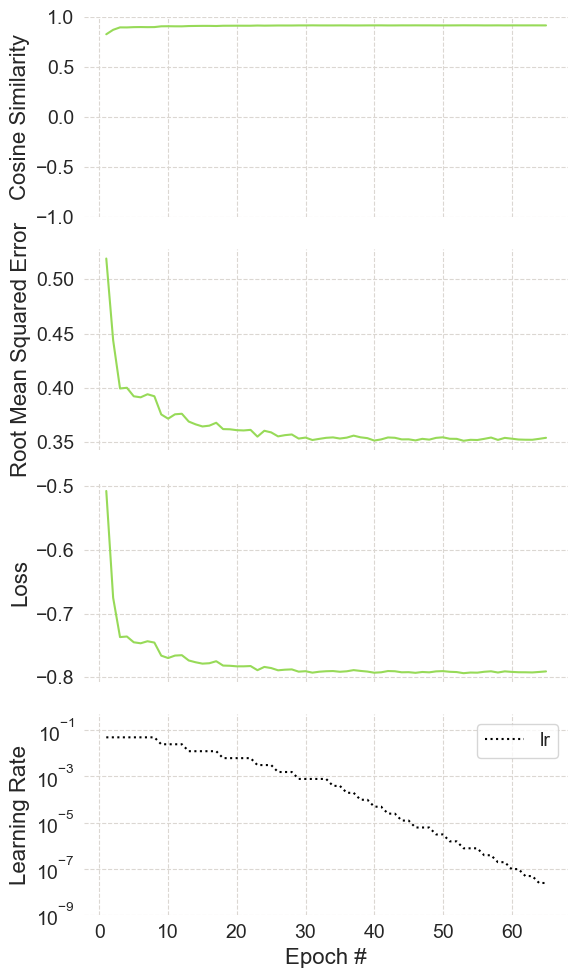

In [65]:
plot_training_history(AE.history, SET_COL_DICT, save_path=f'{DIR_FIG}training_plot_whole.pdf')

In [66]:

# Save Models
AE.save(f'{DIR_DATA}autoencoder_model')
encoder.save(f'{DIR_DATA}encoder_model')
decoder.save(f'{DIR_DATA}decoder_model')

# Load Models
AE = tf.keras.models.load_model(f'{DIR_DATA}autoencoder_model',custom_objects={'custom_loss': custom_loss})
encoder = tf.keras.models.load_model(f'{DIR_DATA}encoder_model'        ,custom_objects={'custom_loss': custom_loss},compile=False)
decoder = tf.keras.models.load_model(f'{DIR_DATA}decoder_model'       ,custom_objects={'custom_loss': custom_loss},compile=False)


INFO:tensorflow:Assets written to: ../data/AE_6D_ALL_X_FC_z/autoencoder_model/assets
INFO:tensorflow:Assets written to: ../data/AE_6D_ALL_X_FC_z/encoder_model/assets
INFO:tensorflow:Assets written to: ../data/AE_6D_ALL_X_FC_z/decoder_model/assets


In [67]:
R_DF_WHOLE, metrics_w = AE_transform(X, AE, encoder, 'training',BATCH_SIZE=BATCH_SIZE)
metrics_w = pd.DataFrame([metrics_w])
# Combine metrics
metrics_df_final = pd.concat([metrics_df, metrics_w])
# Save and Display metrics
metrics_df_final.to_csv(f'{DIR_DATA}metrics.csv', index=False)
metrics_df_final

  1/235 [..............................] - ETA: 40s

2024-07-04 12:13:13.594618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 1s 3ms/step


2024-07-04 12:13:14.565438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


,Set,Sc,RMSE
0,training,0.93 [0.81-0.99],0.28 [0.16-0.49]
1,validation,0.94 [0.83-0.99],0.28 [0.16-0.49]
2,test,0.93 [0.81-0.99],0.28 [0.15-0.5]
0,training,0.93 [0.81-0.99],0.3 [0.17-0.52]


In [ ]:
R_DF_WHOLE.to_csv(f'{DIR_DATA}R_DF_WHOLE.csv')
violins_error(R_DF_WHOLE,ERROR_COL='Sc',SET_COL_DICT=SET_COL_DICT,SAVEFIG=f'{DIR_FIG}/Sc_violins_retrain.png')

In [ ]:
X_heatmaps(X,R_DF_WHOLE,SEL,HM_LIST,SET_COL_DICT,HM_COL_DICT,CT_COL_DICT, DIR_FIG, cmap='viridis',TITLE='SEL_whole',
            relative_range=False, vmin=-2.5,vmax=2.5 )
Sc_selected(R_DF_WHOLE,SEL,'Sc','SEL_whole', DIR_FIG)
Sc_selected(R_DF_WHOLE,SEL,'RMSE','SEL_whole', DIR_FIG)
FC_heatmaps(X,R_DF_WHOLE,SEL,HM_LIST,HM_COL_DICT, DIR_FIG,fc_cmap='RdBu_r',TITLE='SEL_whole',vmax=5,vmin=-5)